Dataset Metadata:
Years Available: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


C:\Users\tilma\AppData\Local\Temp\ipykernel_4512\1306453009.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


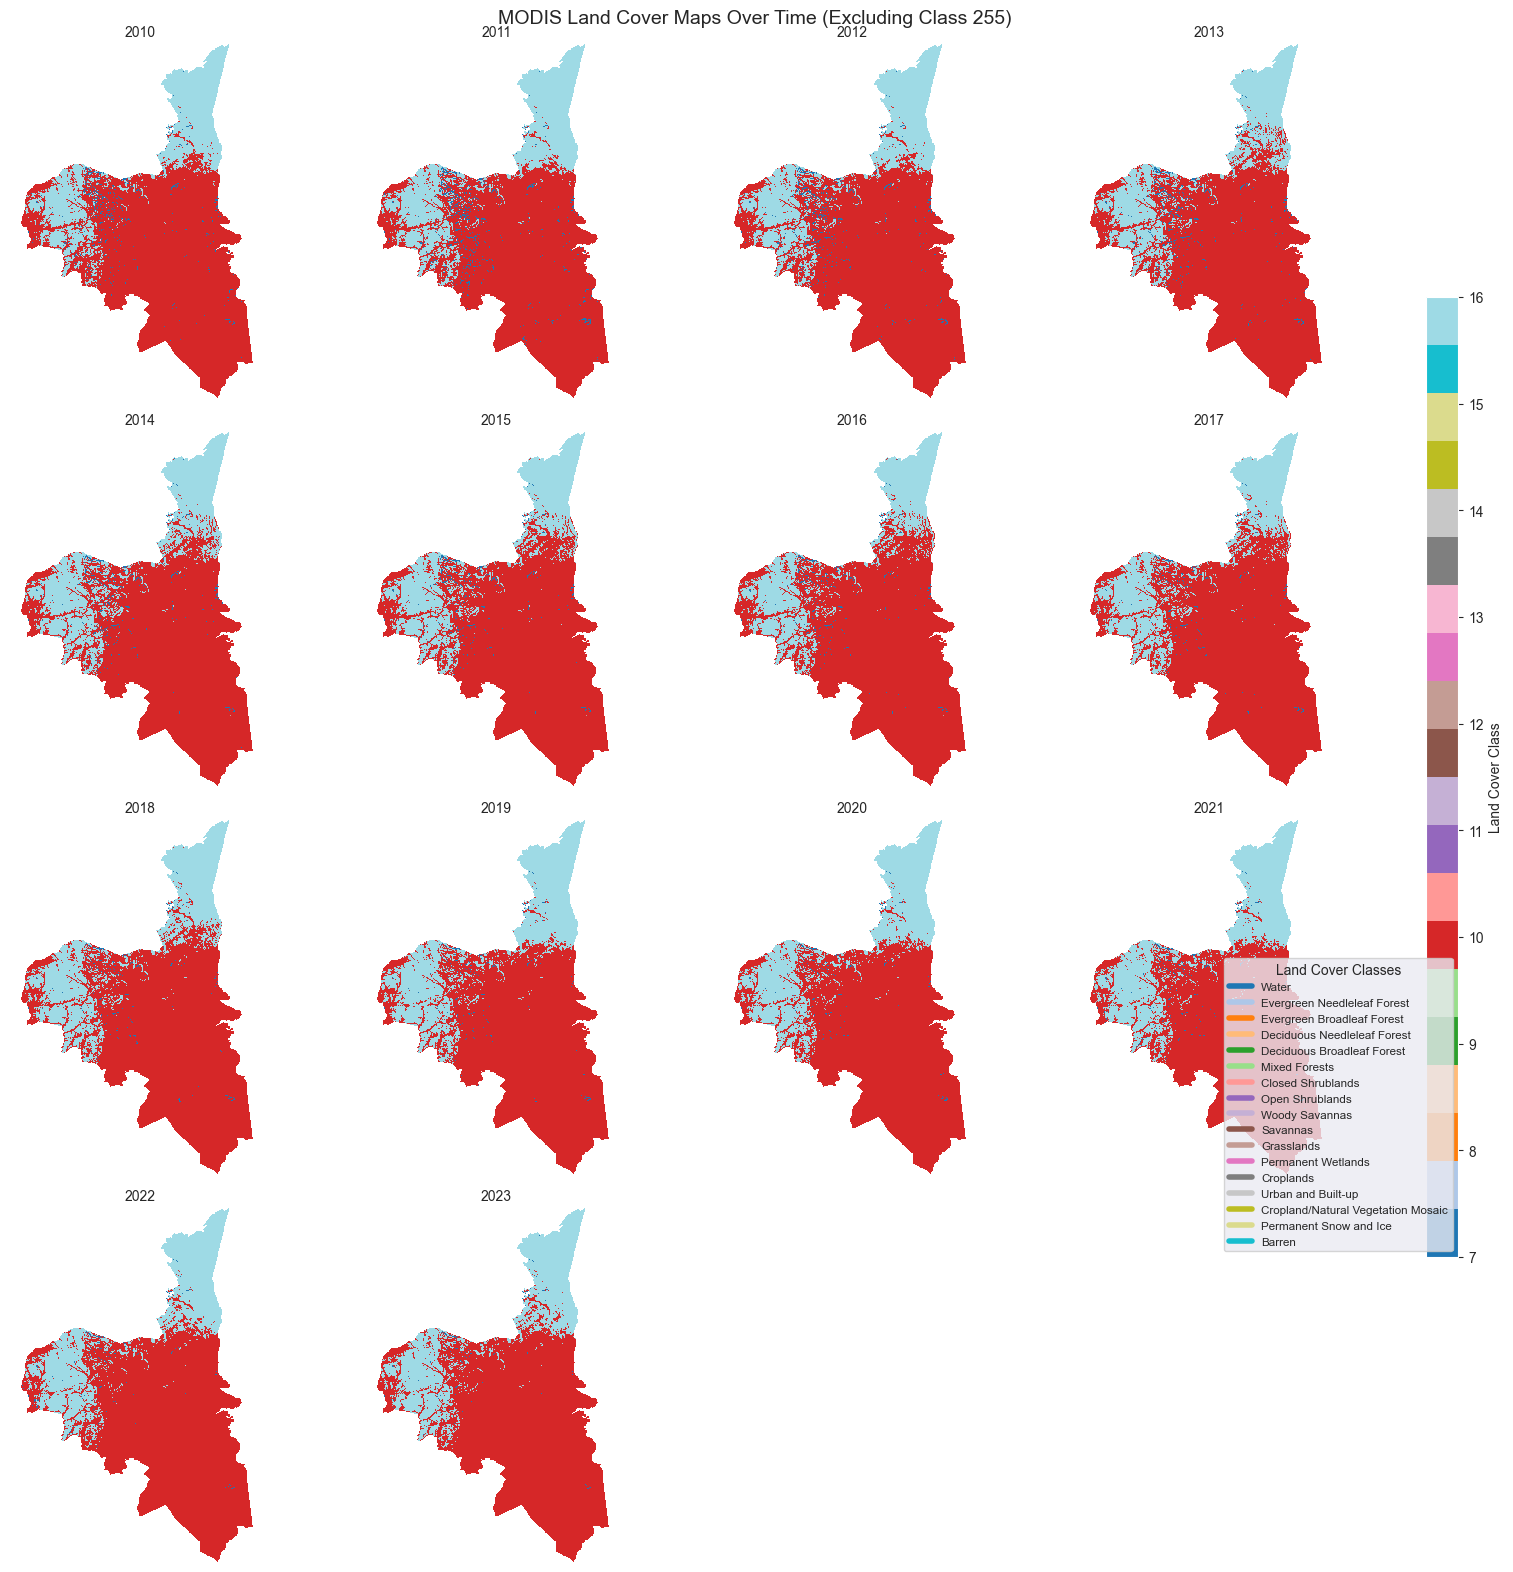

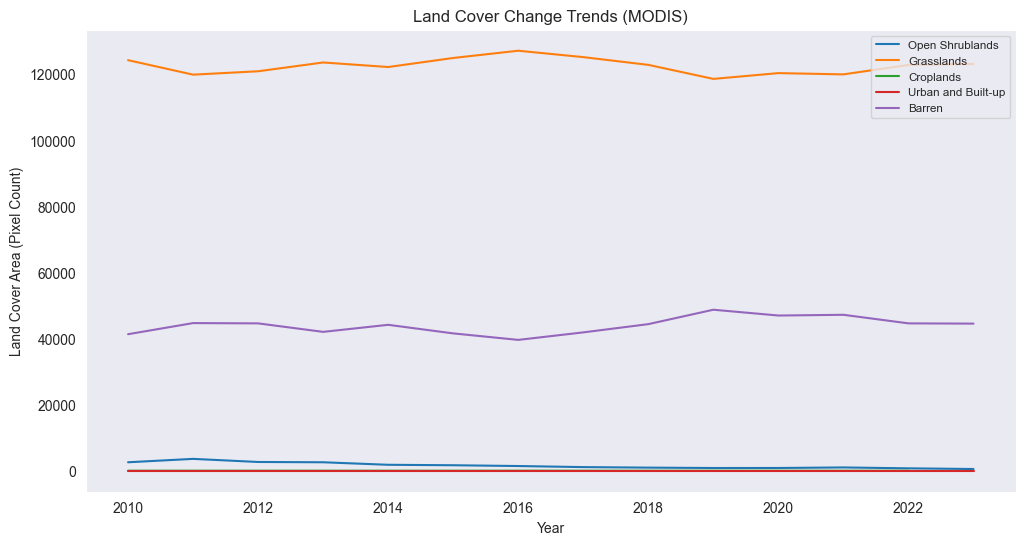

C:\Users\tilma\AppData\Local\Temp\ipykernel_4512\1306453009.py:131: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(temp_path))


✅ Land Cover Change GIF saved as 'land_cover_change.gif'


,Open Shrublands,Grasslands,Croplands,Urban and Built-up,Barren
2010,1.522484,73.897225,0.004161,0.004756,24.571374
2011,2.133023,71.288612,NaN,0.004756,26.573609
2012,1.574204,71.898557,0.000594,0.004756,26.521889
2013,1.521889,73.480489,NaN,0.004756,24.992866
2014,1.068889,72.662474,0.001189,0.004756,26.262692
2015,0.986850,74.290776,0.000594,0.004756,24.717024
2016,0.845362,75.596271,0.004161,0.004756,23.549450
2017,0.652153,74.442370,NaN,0.004756,24.900721
2018,0.558224,73.051863,0.000594,0.004756,26.384562
2019,0.491047,70.524695,0.000594,0.004756,28.978908


In [1]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import math
import seaborn as sns
import imageio
from collections import defaultdict
import pandas as pd

# 🔹 Set the folder containing MODIS Land Cover TIFF files
data_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Modis_Land_Cover_Data"  # Change to your actual folder path

# ✅ Define Correct MODIS Land Cover Classes (Excluding 255)
land_cover_classes = {
    0: "Water",
    1: "Evergreen Needleleaf Forest",
    2: "Evergreen Broadleaf Forest",
    3: "Deciduous Needleleaf Forest",
    4: "Deciduous Broadleaf Forest",
    5: "Mixed Forests",
    6: "Closed Shrublands",
    7: "Open Shrublands",
    8: "Woody Savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent Wetlands",
    12: "Croplands",
    13: "Urban and Built-up",
    14: "Cropland/Natural Vegetation Mosaic",
    15: "Permanent Snow and Ice",
    16: "Barren"  # Use for unknowns
}

# ✅ Remove Invalid Classes (255)
valid_classes = set(land_cover_classes.keys())  # Allow only defined land cover categories

# 🔹 Store Data
land_cover_data = {}  # Stores raster arrays per year
land_cover_stats = {}  # Stores land cover distribution per year
years = []  # Store available years

# 🔹 Load all TIFF files in the folder
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".tif"):  # Process only .tif files
        year = int(filename[:4])  # Extract the year from filename (e.g., "2010LCT.tif")
        years.append(year)
        file_path = os.path.join(data_folder, filename)

        with rasterio.open(file_path) as src:
            raw_data = src.read(1)  # Read the first band (land cover classes)

          # ✅ Remove invalid classes (-128, 255)
            cleaned_data = np.where((raw_data == 255) | (raw_data == -128), np.nan, raw_data)
            land_cover_data[year] = cleaned_data

            # ✅ Compute statistics for land cover distribution (excluding invalid pixels)
            unique, counts = np.unique(cleaned_data[~np.isnan(cleaned_data)], return_counts=True)
            land_cover_stats[year] = {int(k): v for k, v in zip(unique, counts) if int(k) in valid_classes}

# 🔹 Display Dataset Metadata
print("Dataset Metadata:")
print(f"Years Available: {years}")

# ✅ Grid Layout for Visualization
num_years = len(years)
cols = 4  # Number of columns in the grid (adjust as needed)
rows = math.ceil(num_years / cols)  # Automatically calculate required rows

# 🔹 Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figure size
axes = axes.flatten()

# 🔹 Loop through each year and plot land cover data
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"{year}", fontsize=10)
    im = ax.imshow(land_cover_data[year], cmap="tab20", interpolation="nearest")
    ax.axis("off")  # Hide axis for cleaner visualization

# 🔹 Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 🔹 Add a colorbar (common for all subplots)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position the colorbar
fig.colorbar(im, cax=cbar_ax, label="Land Cover Class")

# 🔹 Add Class Labels to Legend
legend_patches = [plt.Line2D([0], [0], color=plt.cm.tab20(i / len(valid_classes)), lw=4, label=label)
                  for i, (lc, label) in enumerate(land_cover_classes.items()) if lc in valid_classes]
plt.legend(handles=legend_patches, loc='lower right', fontsize="small", title="Land Cover Classes")

# 🔹 Show final grid layout
plt.suptitle("MODIS Land Cover Maps Over Time (Excluding Class 255)", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()

# 🔹 Analyze Land Cover Change Over Time
land_cover_trends = defaultdict(list)

for year in years:
    for lc_class, count in land_cover_stats[year].items():
        land_cover_trends[lc_class].append((year, count))

# 🔹 Plot Trends for Key Land Cover Classes
plt.figure(figsize=(12, 6))
for lc_class, trend in land_cover_trends.items():
    years_list, values = zip(*trend)
    plt.plot(years_list, values, label=land_cover_classes.get(lc_class, f"Class {lc_class}"))

plt.xlabel("Year")
plt.ylabel("Land Cover Area (Pixel Count)")
plt.title("Land Cover Change Trends (MODIS)")
plt.legend(loc="upper right", fontsize="small")
plt.grid()
plt.show()

# 🔹 Create Land Cover Animation Over Time
gif_frames = []
for year in years:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Land Cover Change ({year})")
    im = ax.imshow(land_cover_data[year], cmap="tab20", interpolation="nearest")
    plt.colorbar(im, ax=ax)

    # Save each frame
    temp_path = f"frame_{year}.png"
    plt.savefig(temp_path)
    plt.close()
    gif_frames.append(imageio.imread(temp_path))
    os.remove(temp_path)  # Remove temp files after saving

# 🔹 Save GIF Animation
imageio.mimsave("land_cover_change.gif", gif_frames, duration=1)
print("✅ Land Cover Change GIF saved as 'land_cover_change.gif'")

# 🔹 Generate Summary Statistics
summary_stats = {}

for year, stats in land_cover_stats.items():
    total_pixels = sum(stats.values())
    summary_stats[year] = {land_cover_classes.get(k, f"Class {k}"): (v / total_pixels) * 100 for k, v in stats.items()}

df_summary = pd.DataFrame(summary_stats).T
df_summary


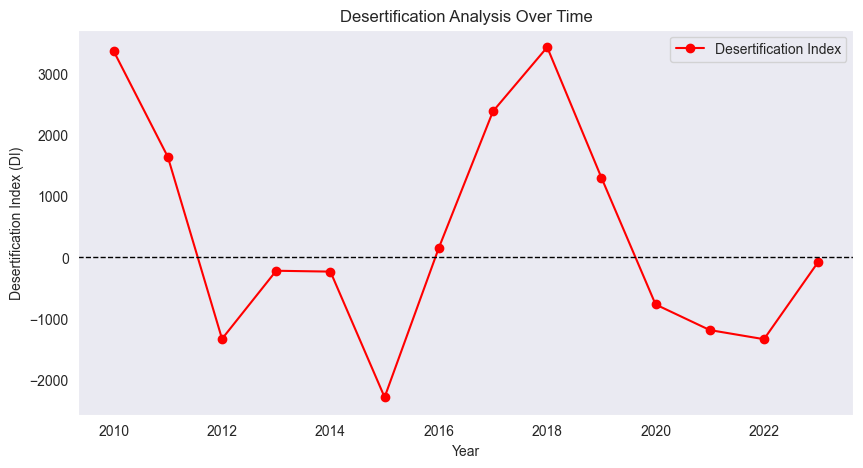

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Extract land cover classes of interest (ensure valid keys exist)
barren_trend = land_cover_trends.get(16, [])  # Barren Land
vegetation_trend = land_cover_trends.get(7, []) + land_cover_trends.get(10, [])  # Shrubs + Grasslands

# ✅ Convert lists of tuples [(year, count), (year, count)] into separate arrays
years_barren, barren_values = zip(*barren_trend) if barren_trend else ([], [])
years_vegetation, vegetation_values = zip(*vegetation_trend) if vegetation_trend else ([], [])

# ✅ Ensure both lists are the same length (only process overlapping years)
common_years = list(set(years_barren) & set(years_vegetation))
common_years.sort()

# 🔹 Get only values for matching years
barren_values = [barren_values[years_barren.index(y)] for y in common_years]
vegetation_values = [vegetation_values[years_vegetation.index(y)] for y in common_years]

# 🔹 Compute changes over time (first-order difference)
delta_barren = np.gradient(barren_values)  # Change in barren land
delta_vegetation = np.gradient(vegetation_values)  # Change in vegetation

# 🔹 Load Climate Data (Dummy values - replace with actual GEE queries)
delta_temperature = np.linspace(0.1, 0.5, len(common_years))  # Fake temperature trend
delta_rainfall = np.linspace(-5, 5, len(common_years))  # Fake rainfall trend

# ✅ Compute the Desertification Index (DI)
DI = delta_barren 

# 🔹 Plot the Desertification Index
plt.figure(figsize=(10, 5))
plt.plot(common_years, DI, marker="o", linestyle="-", color="red", label="Desertification Index")
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Reference line
plt.xlabel("Year")
plt.ylabel("Desertification Index (DI)")
plt.title("Desertification Analysis Over Time")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import math
import imageio

# 🔹 Set the folder containing MODIS Land Cover TIFF files
data_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Modis_Land_Cover_Data"

# ✅ Load Climate Data (Replace with Real Data)
temperature_trend = np.linspace(0.1, 0.5, len(os.listdir(data_folder)))  # Dummy values
rainfall_trend = np.linspace(-5, 5, len(os.listdir(data_folder)))  # Dummy values

# ✅ Initialize Data Storage
land_cover_data = {}
barren_data = {}  # Stores barren land per year
vegetation_data = {}  # Stores vegetation per year (Shrubs + Grasslands)
years = []

# ✅ Load all TIFF files in the folder
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])  # Extract the year
        years.append(year)
        file_path = os.path.join(data_folder, filename)

        with rasterio.open(file_path) as src:
            raw_data = src.read(1)

            # ✅ Remove invalid values (255)
            cleaned_data = np.where(raw_data == 255, np.nan, raw_data)
            land_cover_data[year] = cleaned_data

            # ✅ Extract specific land cover types
            barren_data[year] = np.where(cleaned_data == 16, 1, 0)  # Barren = 1, else 0
            vegetation_data[year] = np.where((cleaned_data == 7) | (cleaned_data == 10), 1, 0)  # Shrubs/Grasslands = 1

# ✅ Compute Yearly Changes in Barren and Vegetation Areas
delta_barren = {}
delta_vegetation = {}

for i in range(1, len(years)):
    year_prev = years[i - 1]
    year_curr = years[i]

    delta_barren[year_curr] = barren_data[year_curr] - barren_data[year_prev]  # Change in barren land
    delta_vegetation[year_curr] = vegetation_data[year_curr] - vegetation_data[year_prev]  # Change in vegetation

# ✅ Compute the Desertification Index (DI) for Each Year
desertification_index = {}

for i in range(1, len(years)):
    year_curr = years[i]

    # Compute DI using pixel-wise calculations
    DI = (delta_barren[year_curr] )#- (delta_vegetation[year_curr])) #+ \
        # (temperature_trend[i] / (rainfall_trend[i] + 1e-6))

    desertification_index[year_curr] = DI  # Store spatial DI values

# ✅ Visualization: Desertification Index Maps Over Time
num_years = len(desertification_index)
cols = 4
rows = math.ceil(num_years / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for i, year in enumerate(desertification_index.keys()):
    ax = axes[i]
    ax.set_title(f"Desertification Index ({year})", fontsize=10)
    im = ax.imshow(desertification_index[year], cmap="YlOrBr", interpolation="nearest", vmin=-1, vmax=2)
    ax.axis("off")  # Hide axis for cleaner visualization

# ✅ Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ✅ Add colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax, label="Desertification Index (DI)")

# ✅ Show final grid layout
plt.suptitle("Spatial Desertification Index Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# ✅ Create an animation of Desertification Index over time
gif_frames = []
for year in desertification_index.keys():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Desertification Index ({year})")
    im = ax.imshow(desertification_index[year], cmap="YlOrBr", interpolation="nearest", vmin=-1, vmax=2)
    plt.colorbar(im, ax=ax)

    temp_path = f"desertification_{year}.png"
    plt.savefig(temp_path)
    plt.close()
    gif_frames.append(imageio.imread(temp_path))
    os.remove(temp_path)

imageio.mimsave("desertification_index.gif", gif_frames, duration=1)
print("✅ Desertification Index GIF saved as 'desertification_index.gif'")


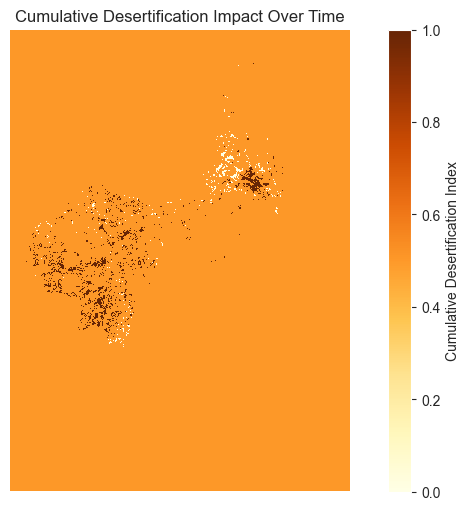

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# ✅ Compute the Cumulative Desertification Index
cumulative_DI = np.zeros_like(next(iter(desertification_index.values())))  # Initialize with zeros

for year in desertification_index.keys():
    cumulative_DI += np.nan_to_num(desertification_index[year])  # Sum up DI over all years

# ✅ Normalize the cumulative DI for visualization
cumulative_DI = (cumulative_DI - np.min(cumulative_DI)) / (np.max(cumulative_DI) - np.min(cumulative_DI))

# ✅ Plot the Overlapped Desertification Map
plt.figure(figsize=(10, 6))
plt.title("Cumulative Desertification Impact Over Time")
im = plt.imshow(cumulative_DI, cmap="YlOrBr", interpolation="nearest")
plt.colorbar(label="Cumulative Desertification Index")
plt.axis("off")  # Hide axes for cleaner visualization
plt.savefig("cumulative_desertification.png", dpi=300, bbox_inches='tight')
plt.show()


📉 Pearson Correlation: -1.000
📊 P-value: 0.00000 (Significance of correlation)


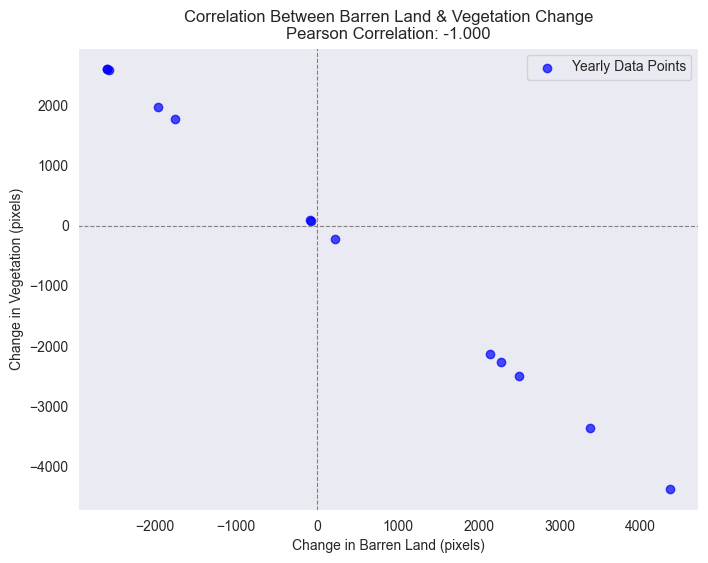

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# ✅ Ensure delta_barren and delta_vegetation are dictionaries (mapping year → change)
years_list = sorted(years[1:])  # Ensure we use the correct years

# ✅ Convert changes into total pixel counts per year
barren_change = [np.nansum(delta_barren[year]) for year in desertification_index.keys()]
vegetation_change = [np.nansum(delta_vegetation[year]) for year in desertification_index.keys()]

# ✅ Compute Pearson correlation coefficient
corr_coeff, p_value = stats.pearsonr(barren_change, vegetation_change)

print(f"📉 Pearson Correlation: {corr_coeff:.3f}")
print(f"📊 P-value: {p_value:.5f} (Significance of correlation)")

# ✅ Scatter Plot for Visualization
plt.figure(figsize=(8, 6))
plt.scatter(barren_change, vegetation_change, color="blue", alpha=0.7, label="Yearly Data Points")
plt.xlabel("Change in Barren Land (pixels)")
plt.ylabel("Change in Vegetation (pixels)")
plt.title(f"Correlation Between Barren Land & Vegetation Change\nPearson Correlation: {corr_coeff:.3f}")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.grid()
plt.legend()
plt.show()


In [106]:
barren_data

{2010: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(769, 565)),
 2011: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(769, 565)),
 2012: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(769, 565)),
 2013: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(769, 565)),
 2014: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0

In [ ]:
delta_barren = {}  # Ensure dictionary format
valid_years = [y for y in years if y in barren_data.keys()]

for i in range(1, len(valid_years)):
    year_prev = valid_years[i - 1]
    year_curr = valid_years[i]

    # ✅ Store changes per year as a dictionary
    delta_barren[year_curr] = barren_data[year_curr] - barren_data[year_prev] 
    delta_vegetation[year_curr] = vegetation_data[year_curr] - vegetation_data[year_prev]
    
flat_barren = []
flat_vegetation = []

for year in desertification_index.keys():
    barren_array = delta_barren[year].flatten()
    vegetation_array = delta_vegetation[year].flatten()

    # Remove NaN values
    valid_mask = (~np.isnan(barren_array)) & (~np.isnan(vegetation_array))
    flat_barren.extend(barren_array[valid_mask])
    flat_vegetation.extend(vegetation_array[valid_mask])

# ✅ Compute Linear Regression for Location-Based Analysis
slope, intercept, r_value, p_value, std_err = linregress(flat_barren, flat_vegetation)
regression_line = np.array(flat_barren) * slope + intercept

# ✅ Create Location-Based Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(flat_barren, flat_vegetation, alpha=0.5, s=5, c=flat_barren, cmap="coolwarm", label="Pixel Data")

# 🔹 Add Regression Line
plt.plot(flat_barren, regression_line, color="red", label=f"Linear Fit (r={r_value:.2f})")

plt.colorbar(label="Δ Barren Land (Pixel Count)")
plt.xlabel("Change in Barren Land (Pixel)")
plt.ylabel("Change in Vegetation (Pixel)")
plt.title(f"Pixel-wise Relationship Between Barren Land & Vegetation Change\nPearson Correlation: {r_value:.3f}")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.grid()
plt.legend()
plt.show()


In [103]:
print(f"Type of delta_barren: {type(delta_barren)}")
print(f"Type of delta_vegetation: {type(delta_vegetation)}")

Type of delta_barren: <class 'numpy.ndarray'>
Type of delta_vegetation: <class 'dict'>


📉 Correlation Coefficient (Delta Barren vs. Precipitation): -0.6523
📊 P-value: 0.0157


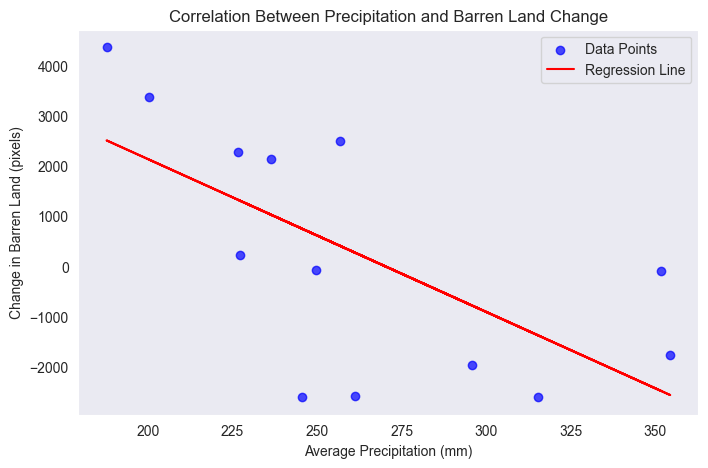

In [85]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.stats as stats

# 🔹 Define folder containing precipitation data
precipitation_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Climate_Precipitation_Data"  # Update path if needed

# ✅ Initialize storage for precipitation data
precipitation_data = {}
years = []

# ✅ Load all precipitation TIFF files
for filename in sorted(os.listdir(precipitation_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])  # Extract year from filename (e.g., "2010R.tif")
        years.append(year)
        file_path = os.path.join(precipitation_folder, filename)

        with rasterio.open(file_path) as src:
            precip_raw = src.read(1)  # Read first band
            precip_cleaned = np.where(precip_raw == src.nodata, np.nan, precip_raw)  # Remove no-data values
            precipitation_data[year] = np.nanmean(precip_cleaned)  # Compute mean precipitation

# ✅ Ensure Years Are Sorted
years.sort()

# ✅ Extract Precipitation Values for Matching Years
precip_values = [precipitation_data[year] for year in desertification_index.keys()]

# ✅ Extract Delta Barren Values for Matching Years
barren_values = [np.nansum(delta_barren[year]) for year in desertification_index.keys()]

# ✅ Compute Pearson Correlation Coefficient
corr_coef, p_value = stats.pearsonr(barren_values, precip_values)

print(f"📉 Correlation Coefficient (Delta Barren vs. Precipitation): {corr_coef:.4f}")
print(f"📊 P-value: {p_value:.4f}")

# ✅ Visualization: Scatter Plot with Regression Line
plt.figure(figsize=(8, 5))
plt.scatter(precip_values, barren_values, color="blue", alpha=0.7, label="Data Points")
plt.xlabel("Average Precipitation (mm)")
plt.ylabel("Change in Barren Land (pixels)")
plt.title("Correlation Between Precipitation and Barren Land Change")

# 🔹 Add Regression Line
slope, intercept, _, _, _ = stats.linregress(precip_values, barren_values)
plt.plot(precip_values, slope * np.array(precip_values) + intercept, color="red", label="Regression Line")

plt.legend()
plt.grid()
plt.show()


📂 Loading 2010R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2010R.tif with shape (65, 46)
📂 Loading 2011R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2011R.tif with shape (65, 46)
📂 Loading 2012R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2012R.tif with shape (65, 46)
📂 Loading 2013R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2013R.tif with shape (65, 46)
📂 Loading 2014R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2014R.tif with shape (65, 46)
📂 Loading 2015R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2015R.tif with shape (65, 46)
📂 Loading 2016R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2016R.tif with shape (65, 46)
📂 Loading 2017R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2017R.tif with shape (65, 46)
📂 Loading 2018R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2018R.tif with shape (65, 46)
📂 Loading 2019R.tif | NoData Value: -3.4028234663852886e+38
✅ Loaded 2019R.tif with shape (65, 46)
📂 Loading 

C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\1510703013.py:67: RuntimeWarning: Mean of empty slice
  mean_precip = np.nanmean(np.array([precipitation_maps[y] for y in valid_years]), axis=0)


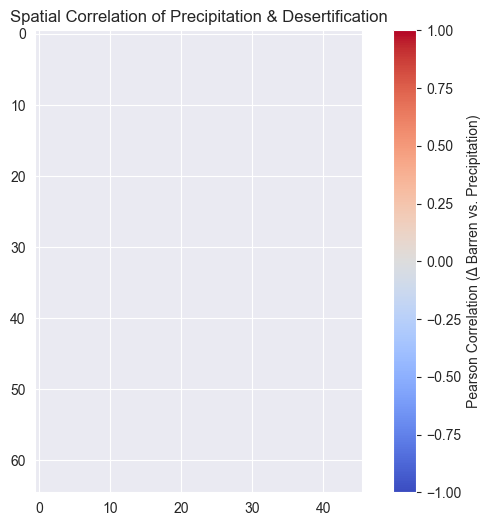

In [86]:
import os
import numpy as np
import rasterio
import scipy.stats as stats
import matplotlib.pyplot as plt

# 🔹 Define data folders
precipitation_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Climate_Precipitation_Data"
land_cover_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Modis_Land_Cover_Data"


# ✅ Load Data Storage
precipitation_maps = {}
barren_maps = {}
years = []

# 🔹 Load Precipitation Data
for filename in sorted(os.listdir(precipitation_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])  # Extract year
        years.append(year)
        file_path = os.path.join(precipitation_folder, filename)

        with rasterio.open(file_path) as src:
            precip_data = src.read(1).astype(float)
            nodata_value = src.nodata

            print(f"📂 Loading {filename} | NoData Value: {nodata_value}")

            # ✅ Replace no-data values with NaN
            if nodata_value is not None:
                precip_data[precip_data == nodata_value] = np.nan

            # ✅ Debug: Check if all values are NaN
            if np.all(np.isnan(precip_data)):
                print(f"⚠️ Warning: No valid precipitation data in {filename}")
            else:
                precipitation_maps[year] = precip_data
                print(f"✅ Loaded {filename} with shape {precip_data.shape}")

# ✅ Debug: Check Loaded Years & Data
print(f"\n🌍 Loaded precipitation years: {list(precipitation_maps.keys())}")

# 🔹 Load Barren Land Data
for filename in sorted(os.listdir(land_cover_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])
        file_path = os.path.join(land_cover_folder, filename)

        with rasterio.open(file_path) as src:
            land_cover = src.read(1)

            # ✅ Mark barren land pixels (1 for barren, 0 for others)
            barren_land = np.where(land_cover == 16, 1, 0)

            # ✅ Store only if not all values are NaN
            if not np.all(np.isnan(barren_land)):
                barren_maps[year] = barren_land
            else:
                print(f"⚠️ Warning: No valid barren land data for {year}")

# ✅ Compute Mean Precipitation Per Pixel
valid_years = [y for y in years if y in precipitation_maps]

if valid_years:
    print(f"✅ Using valid years for precipitation: {valid_years}")
    mean_precip = np.nanmean(np.array([precipitation_maps[y] for y in valid_years]), axis=0)
    print(f"📊 Mean precipitation map shape: {mean_precip.shape}")
else:
    raise ValueError("🚨 No valid precipitation data found!")

# ✅ Compute Pixel-Wise Correlation
correlation_map = np.full_like(mean_precip, np.nan)  # Initialize empty correlation map

for i in range(mean_precip.shape[0]):
    for j in range(mean_precip.shape[1]):
        barren_changes = [barren_maps[y][i, j] for y in valid_years if y in barren_maps]
        precip_values = [precipitation_maps[y][i, j] for y in valid_years if y in precipitation_maps]

        if len(barren_changes) > 1 and len(precip_values) > 1:
            if np.std(barren_changes) > 0 and np.std(precip_values) > 0:  # Avoid constant values
                corr_coef, _ = stats.pearsonr(barren_changes, precip_values)
                correlation_map[i, j] = corr_coef  # Store valid correlation

# ✅ Plot the Correlation Map
plt.figure(figsize=(8, 6))
plt.imshow(correlation_map, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Pearson Correlation (Δ Barren vs. Precipitation)")
plt.title("Spatial Correlation of Precipitation & Desertification")
plt.show()

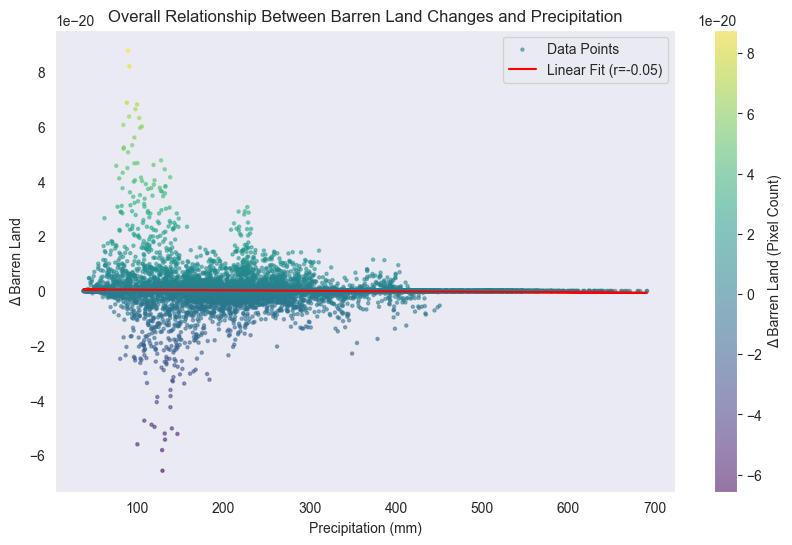

C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\2783078237.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


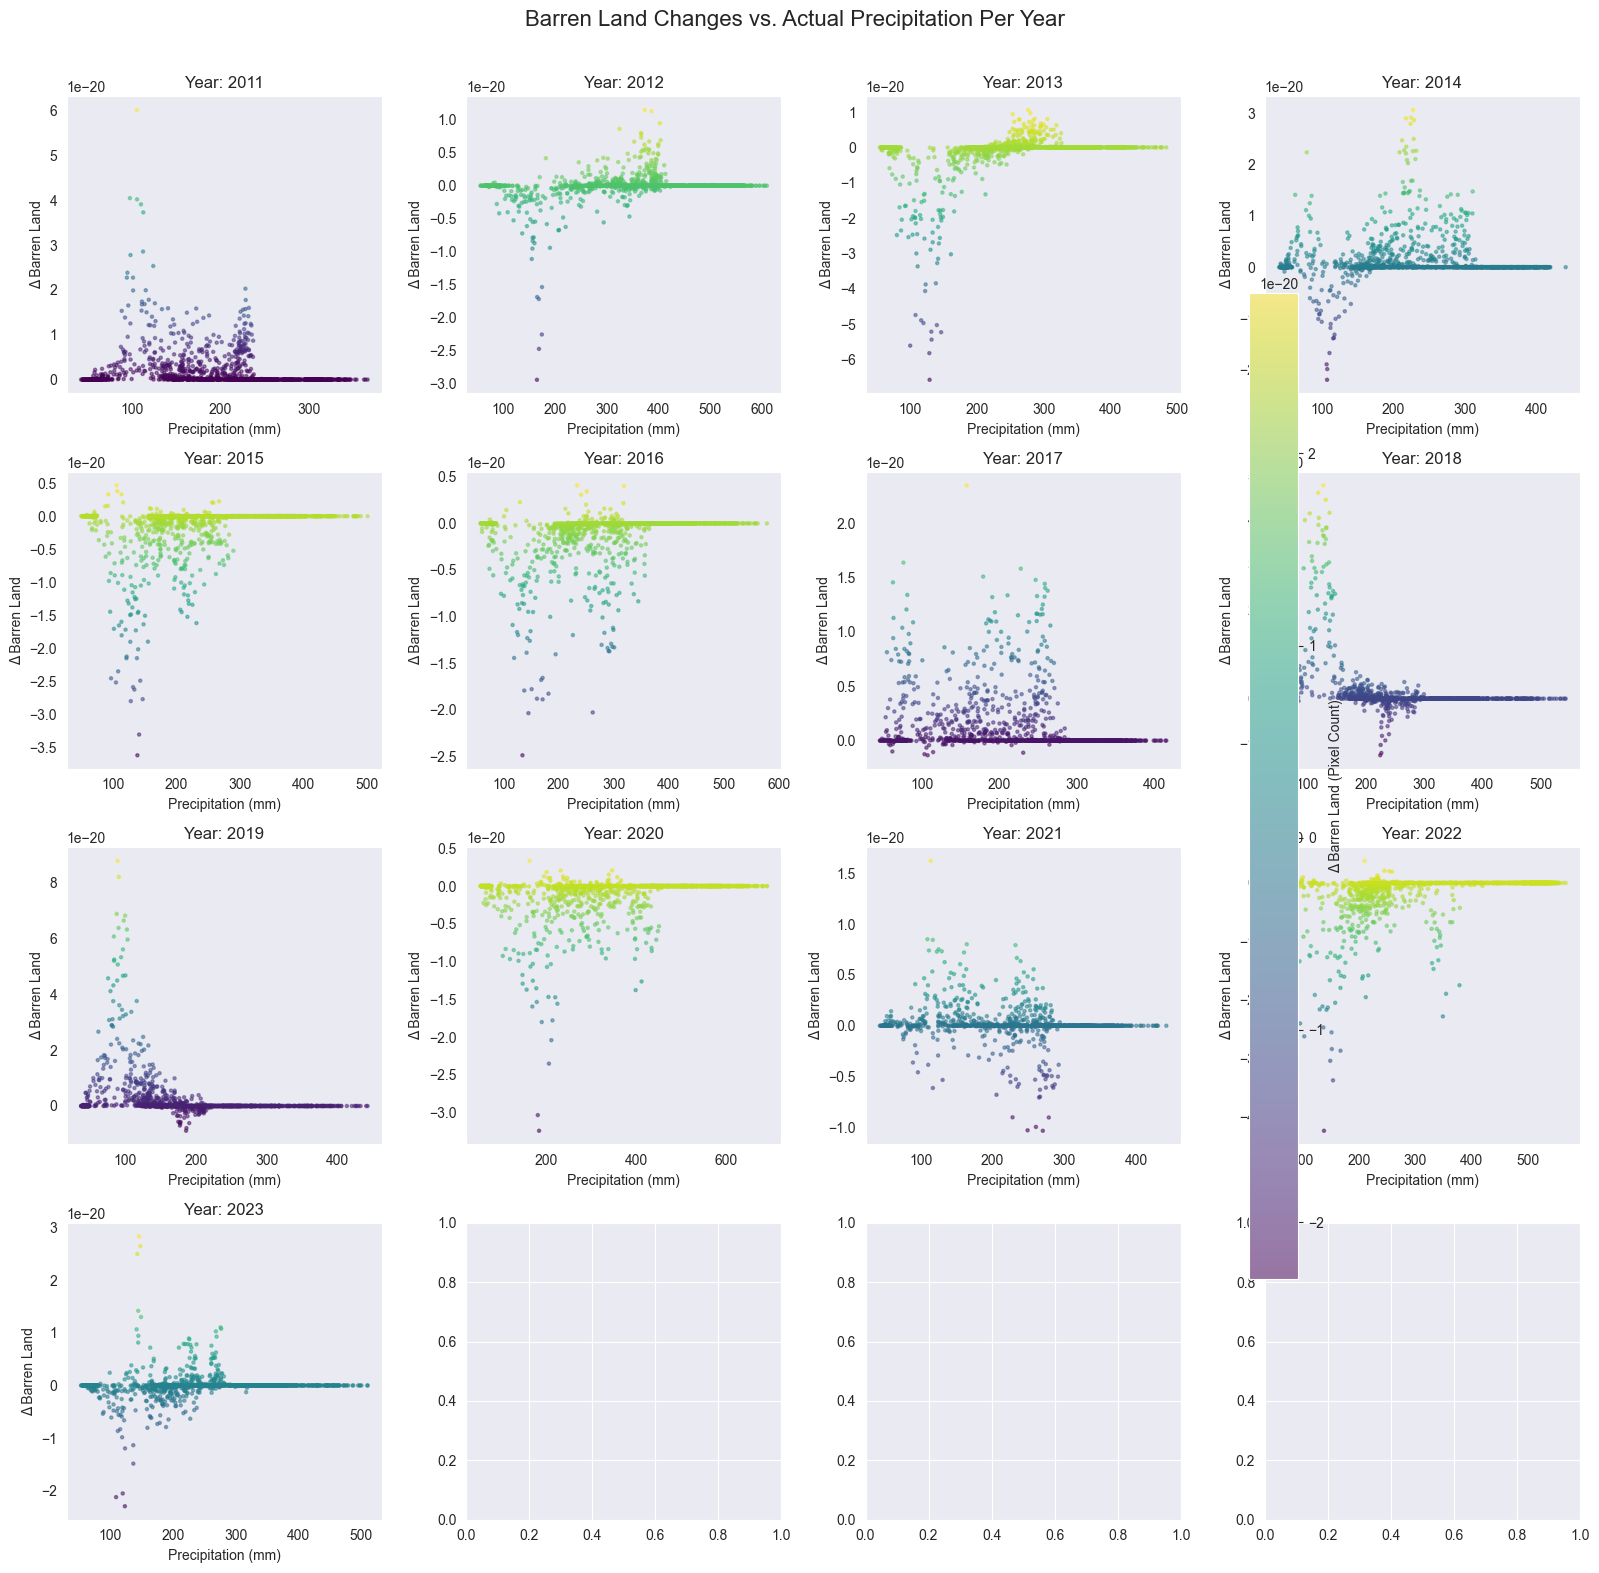

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from skimage.transform import resize

# ✅ Ensure barren land data matches precipitation resolution
target_shape = next(iter(precipitation_maps.values())).shape  # Get shape from precipitation data

for year in valid_years:
    barren_maps[year] = resize(barren_maps[year], target_shape, mode='reflect', anti_aliasing=True)

# ✅ Compute yearly changes in barren land per pixel
all_precip = []
all_barren = []
scatter_data = []

for i in range(1, len(valid_years)):  # Start from second year to compute change
    year_prev = valid_years[i - 1]
    year_curr = valid_years[i]

    # Compute ΔBarren at each pixel
    delta_barren = barren_maps[year_curr] - barren_maps[year_prev]

    # Extract actual precipitation values per pixel for the current year
    actual_precip = precipitation_maps[year_curr]

    # Flatten the arrays to prepare for scatter plot
    flat_precip = actual_precip.flatten()
    flat_barren = delta_barren.flatten()

    # Remove NaN values before plotting
    valid_mask = (~np.isnan(flat_precip)) & (~np.isnan(flat_barren))
    flat_precip = flat_precip[valid_mask]
    flat_barren = flat_barren[valid_mask]

    # Store data for combined visualization
    all_precip.extend(flat_precip)
    all_barren.extend(flat_barren)
    scatter_data.append((flat_precip, flat_barren, year_curr))

# ✅ Create a Combined Scatter Plot with Linear Regression
plt.figure(figsize=(10, 6))

# Scatter plot of all years
plt.scatter(all_precip, all_barren, alpha=0.5, s=5, c=all_barren, cmap="viridis", label="Data Points")

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_precip, all_barren)
regression_line = np.array(all_precip) * slope + intercept
plt.plot(all_precip, regression_line, color="red", label=f"Linear Fit (r={r_value:.2f})")

plt.colorbar(label="Δ Barren Land (Pixel Count)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Δ Barren Land")
plt.title("Overall Relationship Between Barren Land Changes and Precipitation")
plt.legend()
plt.grid()
plt.show()

# ✅ Plot Yearly Scatter Plots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # Adjust based on number of years
axes = axes.flatten()

for i, (flat_precip, flat_barren, year) in enumerate(scatter_data):
    ax = axes[i]
    scatter = ax.scatter(flat_precip, flat_barren, alpha=0.5, s=5, c=flat_barren, cmap="viridis")
    ax.set_xlabel("Precipitation (mm)")
    ax.set_ylabel("Δ Barren Land")
    ax.set_title(f"Year: {year}")
    ax.grid()

# ✅ Adjust layout and colorbar
fig.suptitle("Barren Land Changes vs. Actual Precipitation Per Year", fontsize=16)
fig.colorbar(scatter, ax=axes, shrink=0.8, label="Δ Barren Land (Pixel Count)")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\3029238422.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


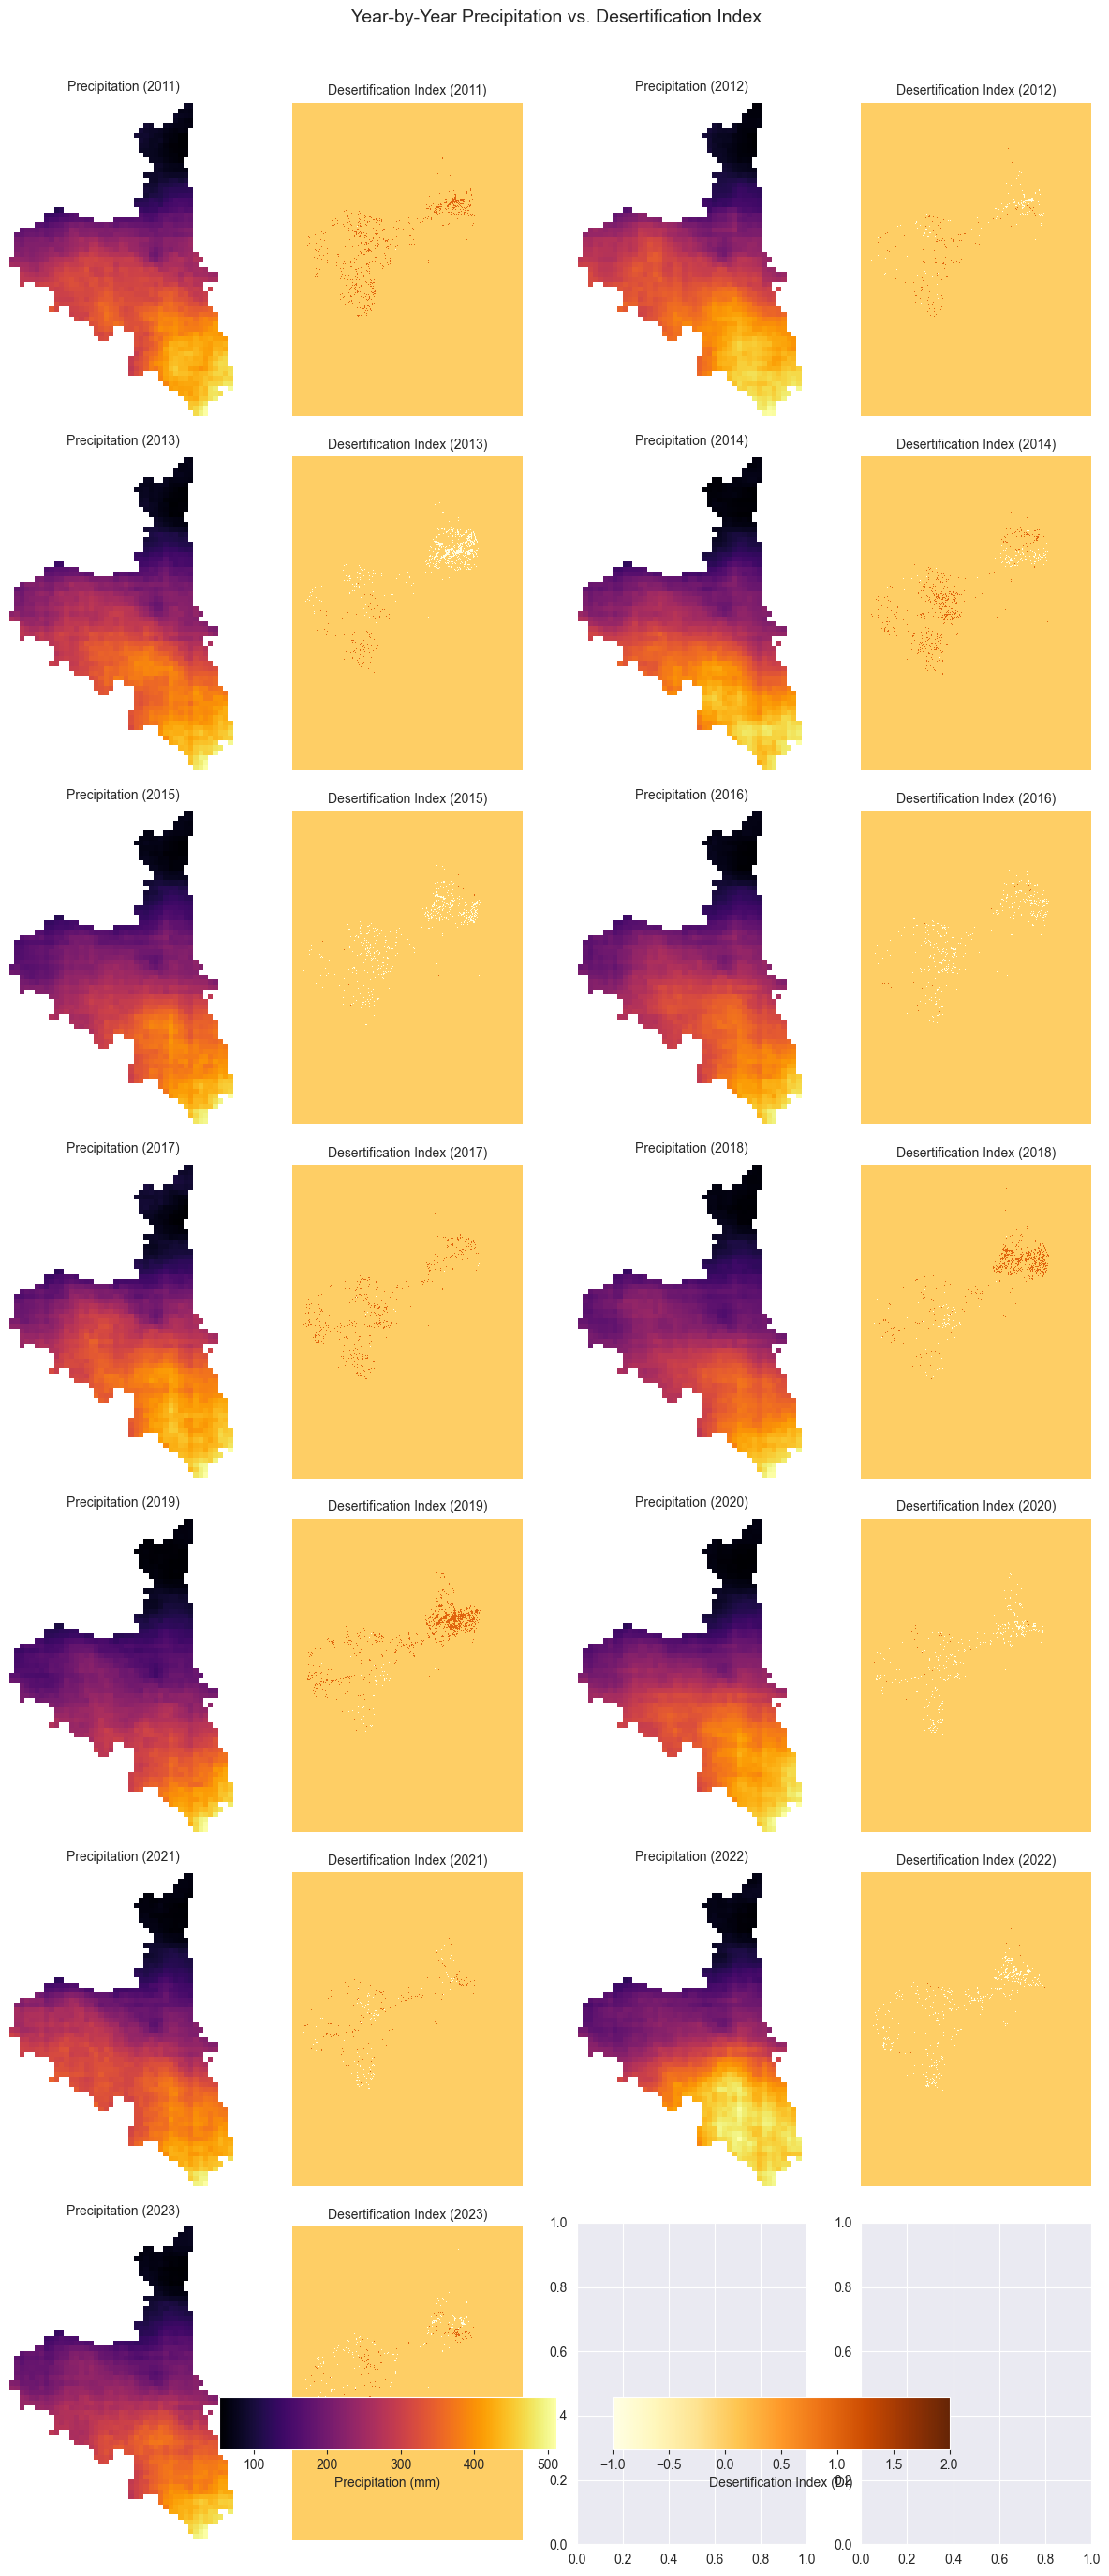

C:\Users\tilma\AppData\Local\Temp\ipykernel_51780\3029238422.py:131: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(temp_path))


✅ Desertification & Precipitation GIF saved as 'desertification_precipitation.gif'


In [95]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import math

# ✅ Define the folder containing MODIS Land Cover TIFF files
precipitation_folder = "Datasets_Hackathon 1/Datasets_Hackathon/Climate_Precipitation_Data"  # Update this to match your folder structure

# ✅ Initialize Data Storage
land_cover_data = {}
barren_data = {}  # Stores barren land per year
vegetation_data = {}  # Stores vegetation per year (Shrubs + Grasslands)
precipitation_data = {}  # Stores precipitation per year
years = []

# ✅ Load Land Cover Data
for filename in sorted(os.listdir(land_cover_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])  # Extract year
        years.append(year)
        file_path = os.path.join(land_cover_folder, filename)

        with rasterio.open(file_path) as src:
            raw_data = src.read(1)

            # ✅ Remove invalid values (255)
            cleaned_data = np.where(raw_data == 255, np.nan, raw_data)
            land_cover_data[year] = cleaned_data

            # ✅ Extract specific land cover types
            barren_data[year] = np.where(cleaned_data == 16, 1, 0)  # Barren = 1, else 0
            vegetation_data[year] = np.where((cleaned_data == 7) | (cleaned_data == 10), 1, 0)  # Shrubs/Grasslands = 1

# ✅ Load Precipitation Data
for filename in sorted(os.listdir(precipitation_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])  # Extract year
        file_path = os.path.join(precipitation_folder, filename)

        with rasterio.open(file_path) as src:
            precip_raw = src.read(1).astype(float)  # Read first band
            no_data_value = src.nodata
            precip_raw[precip_raw == no_data_value] = np.nan  # Remove no-data values
            precipitation_data[year] = precip_raw

# ✅ Compute Yearly Changes in Barren and Vegetation Areas
delta_barren = {}
delta_vegetation = {}

for i in range(1, len(years)):
    year_prev = years[i - 1]
    year_curr = years[i]

    delta_barren[year_curr] = barren_data[year_curr] - barren_data[year_prev]  # Change in barren land
    delta_vegetation[year_curr] = vegetation_data[year_curr] - vegetation_data[year_prev]  # Change in vegetation

# ✅ Compute the Desertification Index (DI) for Each Year
desertification_index = {}

for i in range(1, len(years)):
    year_curr = years[i]

    # Compute DI using pixel-wise calculations
    DI = delta_barren[year_curr]  # You can modify this equation to include vegetation changes
    desertification_index[year_curr] = DI  # Store spatial DI values

# ✅ Visualization: Precipitation & Desertification Index Maps Over Time
num_years = len(desertification_index)
cols = 2  # One for precipitation, one for desertification
rows = math.ceil(num_years / cols)

fig, axes = plt.subplots(rows, cols * 2, figsize=(cols * 6, rows * 4))

for i, year in enumerate(desertification_index.keys()):
    ax1 = axes[i // cols, (i % cols) * 2]  # Left column: Precipitation
    ax2 = axes[i // cols, (i % cols) * 2 + 1]  # Right column: Desertification

    # 🔹 Plot Precipitation
    if year in precipitation_data:
        ax1.set_title(f"Precipitation ({year})", fontsize=10)
        im1 = ax1.imshow(precipitation_data[year], cmap="inferno", interpolation="nearest")
        ax1.axis("off")
    else:
        ax1.set_title(f"Precipitation ({year}) - Missing Data", fontsize=10)
        ax1.axis("off")

    # 🔹 Plot Desertification Index
    ax2.set_title(f"Desertification Index ({year})", fontsize=10)
    im2 = ax2.imshow(desertification_index[year], cmap="YlOrBr", interpolation="nearest", vmin=-1, vmax=2)
    ax2.axis("off")

# ✅ Add colorbars at the bottom with smaller size
fig.subplots_adjust(bottom=0.15)  # Adjust the figure layout to fit the legend
cbar_ax1 = fig.add_axes([0.2, 0.05, 0.3, 0.02])  # [left, bottom, width, height]
cbar_ax2 = fig.add_axes([0.55, 0.05, 0.3, 0.02])

fig.colorbar(im1, cax=cbar_ax1, orientation="horizontal", label="Precipitation (mm)")
fig.colorbar(im2, cax=cbar_ax2, orientation="horizontal", label="Desertification Index (DI)")


# ✅ Show final visualization
plt.suptitle("Year-by-Year Precipitation vs. Desertification Index", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# ✅ Create an animation combining both
gif_frames = []
for year in desertification_index.keys():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 🔹 Plot Precipitation
    ax1 = axes[0]
    if year in precipitation_data:
        ax1.set_title(f"Precipitation ({year})", fontsize=10)
        im1 = ax1.imshow(precipitation_data[year], cmap="inferno", interpolation="nearest")
        ax1.axis("off")
        plt.colorbar(im1, ax=ax1, label="Precipitation (mm)")

    # 🔹 Plot Desertification Index
    ax2 = axes[1]
    ax2.set_title(f"Desertification Index ({year})", fontsize=10)
    im2 = ax2.imshow(desertification_index[year], cmap="YlOrBr", interpolation="nearest", vmin=-1, vmax=2)
    ax2.axis("off")
    plt.colorbar(im2, ax=ax2, label="Desertification Index (DI)")

    # Save frames for GIF
    temp_path = f"desertification_precipitation_{year}.png"
    plt.savefig(temp_path)
    plt.close()
    gif_frames.append(imageio.imread(temp_path))
    os.remove(temp_path)

# ✅ Save animated GIF
imageio.mimsave("desertification_precipitation.gif", gif_frames, duration=1.5)
print("✅ Desertification & Precipitation GIF saved as 'desertification_precipitation.gif'")
